# Setup

In [200]:
%run notebook_setup.py

Now you can import modules from the project root: /home/opscenter/kaggle/m5-forecasting


In [201]:
import numpy as np
import pandas as pd
import duckdb as ddb

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px

con = ddb.connect()

# Load data

In [202]:
SALES_DATA_PATH = '../data/processed/sales_train_validation.parquet'

In [203]:
query = f"""
SELECT
id,
item_id,
store_id,
date,
sales
FROM read_parquet('{SALES_DATA_PATH}')
WHERE year = 2015 AND quarter = 2
"""

sales_data = con.query(query).to_df()

In [204]:
sales_data.head()

,id,item_id,store_id,date,sales
0,FOODS_1_001_CA_1_validation,FOODS_1_001,CA_1,2015-04-01,0
1,FOODS_1_001_CA_1_validation,FOODS_1_001,CA_1,2015-04-02,1
2,FOODS_1_001_CA_1_validation,FOODS_1_001,CA_1,2015-04-03,0
3,FOODS_1_001_CA_1_validation,FOODS_1_001,CA_1,2015-04-04,2
4,FOODS_1_001_CA_1_validation,FOODS_1_001,CA_1,2015-04-05,2


In [205]:
len(sales_data)

2774590

In [206]:
query = f"""
SELECT
  id, item_id, store_id,
  MIN(CASE WHEN sales > 0 THEN date END) AS first_sale_date,
  MAX(CASE WHEN sales > 0 THEN date END) AS last_sale_date,
  DATE_DIFF('day',
    MIN(CASE WHEN sales > 0 THEN date END),
    MAX(CASE WHEN sales > 0 THEN date END)
  ) AS sales_window_days,
  SUM(CASE WHEN sales > 0 THEN 1 ELSE 0 END) AS selling_days,
  AVG(NULLIF(sales,0)) AS avg_sales,
  STDDEV_POP(NULLIF(sales,0)) AS std_sales
FROM sales_data
GROUP BY store_id, item_id, id
HAVING SUM(CASE WHEN sales > 0 THEN 1 ELSE 0 END) > 0
ORDER BY item_id, store_id
"""

demand_summary = con.query(query).to_df().round(3)

In [207]:
demand_summary.head(10)

,id,item_id,store_id,first_sale_date,last_sale_date,sales_window_days,selling_days,avg_sales,std_sales
0,FOODS_1_001_CA_1_validation,FOODS_1_001,CA_1,2015-04-02,2015-06-27,86,35.0,1.600,0.868
1,FOODS_1_001_CA_2_validation,FOODS_1_001,CA_2,2015-04-02,2015-06-29,88,31.0,2.194,1.874
2,FOODS_1_001_CA_3_validation,FOODS_1_001,CA_3,2015-04-04,2015-06-30,87,28.0,2.464,3.300
3,FOODS_1_001_CA_4_validation,FOODS_1_001,CA_4,2015-04-08,2015-06-26,79,21.0,1.238,0.426
4,FOODS_1_001_TX_1_validation,FOODS_1_001,TX_1,2015-04-04,2015-06-30,87,28.0,1.321,0.710
5,FOODS_1_001_TX_2_validation,FOODS_1_001,TX_2,2015-04-02,2015-06-15,74,27.0,1.370,0.554
6,FOODS_1_001_TX_3_validation,FOODS_1_001,TX_3,2015-04-01,2015-06-27,87,26.0,2.000,1.359
7,FOODS_1_001_WI_1_validation,FOODS_1_001,WI_1,2015-04-04,2015-06-28,85,26.0,1.192,0.482
8,FOODS_1_001_WI_2_validation,FOODS_1_001,WI_2,2015-04-01,2015-06-30,90,29.0,1.241,0.677
9,FOODS_1_001_WI_3_validation,FOODS_1_001,WI_3,2015-04-02,2015-06-24,83,12.0,1.167,0.553


# Processing data

In [208]:
def classify_demand(df):
    """
    Classify each item into a demand type following Syntetos & Boylan (2005).

    Categories:
        - Smooth       : ADI < 1.32  and CV² < 0.49
        - Intermittent : ADI ≥ 1.32 and CV² < 0.49
        - Erratic      : ADI < 1.32  and CV² ≥ 0.49
        - Lumpy        : ADI ≥ 1.32 and CV² ≥ 0.49
    """

    # Thresholds defined in the literature
    ADI_THR = 1.32
    CV2_THR = 0.49

    # Compute demand metrics
    df["ADI"] = (df["sales_window_days"] / df["selling_days"]).round(3)
    df["CV2"] = ((df["std_sales"] / df["avg_sales"]) ** 2).round(3)

    # Classification rules
    conditions = [
        (df["ADI"] < ADI_THR) & (df["CV2"] < CV2_THR),   # Smooth
        (df["ADI"] >= ADI_THR) & (df["CV2"] < CV2_THR),  # Intermittent
        (df["ADI"] < ADI_THR) & (df["CV2"] >= CV2_THR),  # Erratic
        (df["ADI"] >= ADI_THR) & (df["CV2"] >= CV2_THR)  # Lumpy
    ]
    labels = ["Smooth", "Intermittent", "Erratic", "Lumpy"]

    # Assign demand category
    df["demand_type"] = np.select(conditions, labels, default="Unknown")

    return df

In [209]:
def tag_insufficient_data(df, ratio=0.2):
    """
    Tag items as 'Insufficient data' when their sales history 
    is too short to provide reliable classification.

    Parameters
    ----------
    df : DataFrame
        Must contain the column 'sales_window_days'.
    ratio : float, default=0.2
        Proportion of the maximum sales window used as threshold.

    Returns
    -------
    DataFrame
        Same DataFrame with updated 'demand_type'.
    """

    # Threshold: % of the maximum observed sales window
    sales_threshold = int(df['sales_window_days'].max() * ratio)
    print(f"Sales threshold (days with sales) for 'Insufficient data': {sales_threshold}")

    # Relabel demand_type for items below threshold
    df['demand_type'] = np.where(
        df['sales_window_days'] < sales_threshold,
        'Insufficient data',
        df['demand_type']
    )

    return df

In [210]:
def format_demand_summary(df,
                          demand_categories=['Smooth', 'Intermittent', 'Erratic', 'Lumpy', 'Insufficient data']):
    """
    Format the demand summary DataFrame:
      - Casts columns to consistent dtypes.
      - Orders demand categories.
      - Rounds numeric values for readability.

    Parameters
    ----------
    df : DataFrame
        Input DataFrame with demand summary metrics.
    demand_categories : list
        Ordered list of demand categories (e.g., 
        ["Smooth", "Intermittent", "Erratic", "Lumpy", "Insufficient data"]).

    Returns
    -------
    DataFrame
        Formatted DataFrame with standardized types and categories.
    """

    # Target dtypes for each column
    dtypes_dict = {
        "id": "category",
        "first_sale_date": "datetime64[ns]",
        "last_sale_date": "datetime64[ns]",
        "sales_window_days": "Int16",
        "selling_days": "Int16",
        "avg_sales": "Float32",
        "std_sales": "Float32",
        "ADI": "Float32",
        "CV2": "Float32",
    }

    # Ensure demand_type follows a fixed, ordered categorization
    df["demand_type"] = pd.Categorical(
        df["demand_type"],
        categories=demand_categories,
        ordered=True
    )

    # Apply data types and round numeric columns
    df = df.astype(dtypes_dict).round(3)

    return df

In [211]:
demand_summary = (
    demand_summary
    .pipe(classify_demand)
    .pipe(tag_insufficient_data)
    .pipe(format_demand_summary)
)

Sales threshold (days with sales) for 'Insufficient data': 18


In [224]:
demand_summary.to_parquet("../data/processed/demand_analysis_q2_2015.parquet")

# EDA

In [212]:
query = f"""
SELECT
date,
SUM(sales) AS sales
FROM sales_data
GROUP BY date
ORDER BY date
"""

sales_data_agg = con.query(query).to_df()

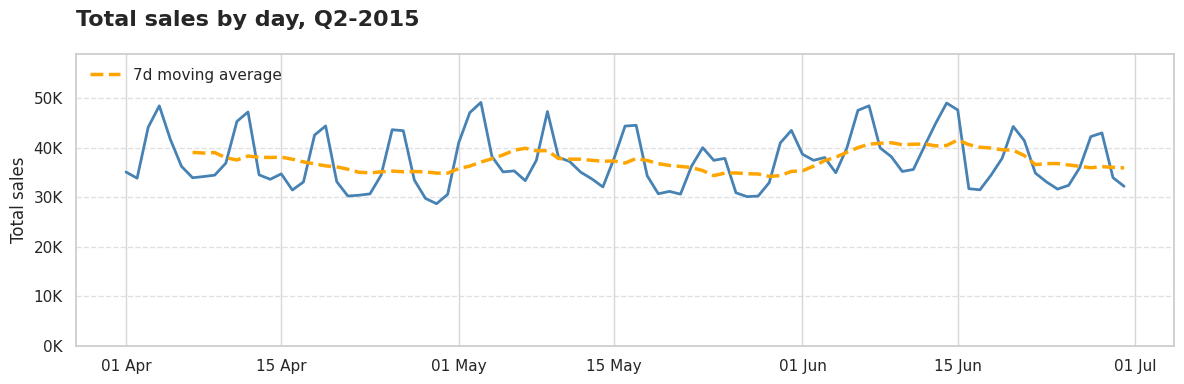

In [213]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

plt.figure(figsize=(12,4))

sns.lineplot(
    data=sales_data_agg,
    x="date",
    y="sales",
    linewidth=2,
    color="steelblue"
)

sns.lineplot(
    data=sales_data_agg.rolling(7, on="date").mean(),
    x="date",
    y="sales",
    label="7d moving average",
    linewidth=2.5,
    linestyle="--",
    color="orange"
)

plt.ylim(0, sales_data_agg["sales"].max() * 1.2)

ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x/1000)}K"))

locator = mdates.DayLocator(bymonthday=[1, 15])
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
plt.xticks(rotation=0)

plt.title("Total sales by day, Q2-2015", fontsize=16, weight="bold", loc="left", pad=20)
plt.xlabel("")
plt.ylabel("Total sales")

ax.yaxis.grid(True, linestyle="--", linewidth=1, alpha=0.6)
ax.xaxis.grid(True, linestyle="-", linewidth=1, alpha=0.8)

plt.legend(loc="upper left", frameon=False)

plt.tight_layout()
plt.show()

In [214]:
unique_items = sales_data['item_id'].nunique()
unique_stores = sales_data['store_id'].nunique()
unique_days = sales_data['date'].nunique()

In [215]:
print(unique_items, unique_stores, unique_days)

3049 10 91


In [216]:
sales_data_agg['sales'].describe().round(0).astype('int') / 1000

count     0.091
mean     37.385
std       5.529
min      28.667
25%      33.220
50%      35.945
75%      41.524
max      49.102
Name: sales, dtype: float64

# First exameple

In [217]:
query = """
SELECT * 
FROM sales_data
WHERE id = 'HOBBIES_1_366_CA_1_validation'
"""

example_item = con.query(query).to_df()

/tmp/ipykernel_1794678/3268067434.py:33: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



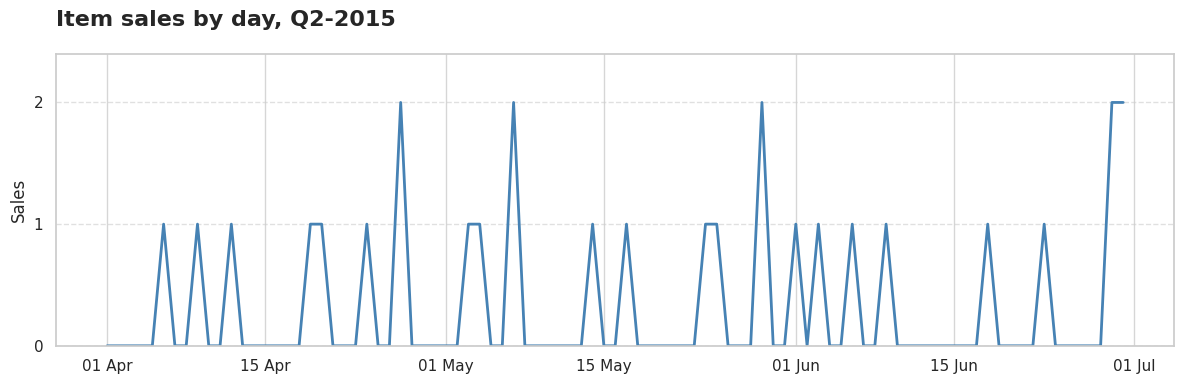

In [218]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

plt.figure(figsize=(12,4))

sns.lineplot(
    data=example_item,
    x="date",
    y="sales",
    linewidth=2,
    color="steelblue"
)

plt.ylim(0, example_item["sales"].max() * 1.2)

ax = plt.gca()
ax.yaxis.set_major_locator(mticker.MultipleLocator(1))

locator = mdates.DayLocator(bymonthday=[1, 15])
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
plt.xticks(rotation=0)

plt.title("Item sales by day, Q2-2015", fontsize=16, weight="bold", loc="left", pad=20)
plt.xlabel("")
plt.ylabel("Sales")

ax.yaxis.grid(True, linestyle="--", linewidth=1, alpha=0.6)
ax.xaxis.grid(True, linestyle="-", linewidth=1, alpha=0.8)

plt.legend(loc="upper left", frameon=False)

plt.tight_layout()
plt.show()

## a) Demand Summary

In [219]:
demand_summary_gb = demand_summary.groupby('demand_type', observed = True, as_index=False).agg(
    total = ('id', 'count'),
    mean_sales_window_days = ('sales_window_days', 'mean'),
    mean_selling_days = ('selling_days', 'mean'),
    mean_adi = ('ADI', 'mean'),
    mean_avg_sales = ('avg_sales', 'mean'),
    mean_std_sales = ('std_sales', 'mean'),
    mean_cv2 = ('CV2', 'mean')
).round(2)

demand_summary_gb['total_proportion'] = (demand_summary_gb['total'] / demand_summary_gb['total'].sum()).round(4)

demand_summary_gb['demand_type'] = pd.Categorical(
        demand_summary_gb['demand_type'],
        categories=['Smooth', 'Intermittent', 'Erratic', 'Lumpy', 'Insufficient data'],
        ordered=True
    )

demand_summary_gb

,demand_type,total,mean_sales_window_days,mean_selling_days,mean_adi,mean_avg_sales,mean_std_sales,mean_cv2,total_proportion
0,Smooth,4026,84.61,75.8,1.13,5.14,2.72,0.33,0.1388
1,Intermittent,20588,78.28,29.5,4.01,1.57,0.73,0.21,0.7097
2,Erratic,901,83.84,72.47,1.16,5.4,4.66,0.72,0.0311
3,Lumpy,2631,81.61,38.81,2.72,2.8,2.52,0.78,0.0907
4,Insufficient data,865,6.1,3.7,1.47,1.63,0.45,0.1,0.0298


In [220]:
query="""
SELECT
demand_type,
total_proportion,
mean_sales_window_days,
mean_selling_days,
mean_adi,
mean_avg_sales,
mean_cv2
FROM demand_summary_gb
"""

con.query(query).to_df().round(2)

,demand_type,total_proportion,mean_sales_window_days,mean_selling_days,mean_adi,mean_avg_sales,mean_cv2
0,Smooth,0.14,84.61,75.80,1.13,5.14,0.33
1,Intermittent,0.71,78.28,29.50,4.01,1.57,0.21
2,Erratic,0.03,83.84,72.47,1.16,5.40,0.72
3,Lumpy,0.09,81.61,38.81,2.72,2.80,0.78
4,Insufficient data,0.03,6.10,3.70,1.47,1.63,0.10


In [221]:
query = """
SELECT * 
FROM demand_summary
WHERE id = 'HOBBIES_1_366_CA_1_validation'
"""

demand_example_item = con.query(query).to_df()

demand_example_item

,id,item_id,store_id,first_sale_date,last_sale_date,sales_window_days,selling_days,avg_sales,std_sales,ADI,CV2,demand_type
0,HOBBIES_1_366_CA_1_validation,HOBBIES_1_366,CA_1,2015-04-06,2015-06-30,85,23,1.217,0.412,3.696,0.115,Intermittent


In [222]:
palette = {
    "Smooth": "#4A90E2",           # azul fuerte
    "Erratic": "#4A90E2",          # azul fuerte
    "Lumpy": "#4A90E2",            # azul fuerte
    "Intermittent": "#F28E2B",     # naranjo fuerte
    "Insufficient data": "#7F7F7F" # gris medio
}

In [223]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10,5))

ax = sns.barplot(   # <- aquí guardamos el eje
    data=demand_summary_gb,
    x='demand_type',
    y='count_pct',
    palette=palette,
    hue='demand_type',
    legend=False
)

ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=0))
plt.ylim(0, 1)

plt.title("Distribution of demand patterns across item–store combinations (Q2 2015)", fontsize=14, weight="bold", loc='center', pad=20)
plt.xlabel("")
plt.ylabel("Proportion of total")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height*100:.0f}%',   # sin decimales
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=10, weight='bold')

plt.grid(axis='y', alpha=0.7, linestyle='--')

plt.show()

ValueError: Could not interpret value `count_pct` for `y`. An entry with this name does not appear in `data`.

<Figure size 1000x500 with 0 Axes>

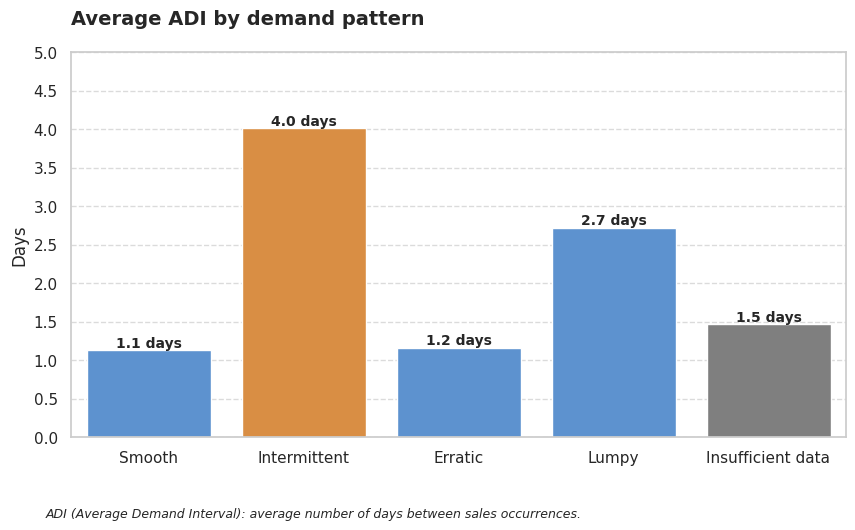

In [ ]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10,5))

ax = sns.barplot(
    data=demand_summary_gb,
    x='demand_type',
    y='mean_adi',
    palette=palette,
    hue='demand_type',
    legend=False,
    dodge=False
)

plt.title("Average ADI by demand pattern", fontsize=14, weight="bold", loc='left', pad=20)
plt.xlabel("")
plt.ylabel("Days")

plt.ylim(0, 5)
plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(0.5))

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f} days',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=10, weight='bold')

plt.grid(axis='y', alpha=0.7, linestyle='--')


plt.figtext(0.1, -0.05,
            "ADI (Average Demand Interval): average number of days between sales occurrences.",
            ha="left", fontsize=9, style="italic")

plt.show()

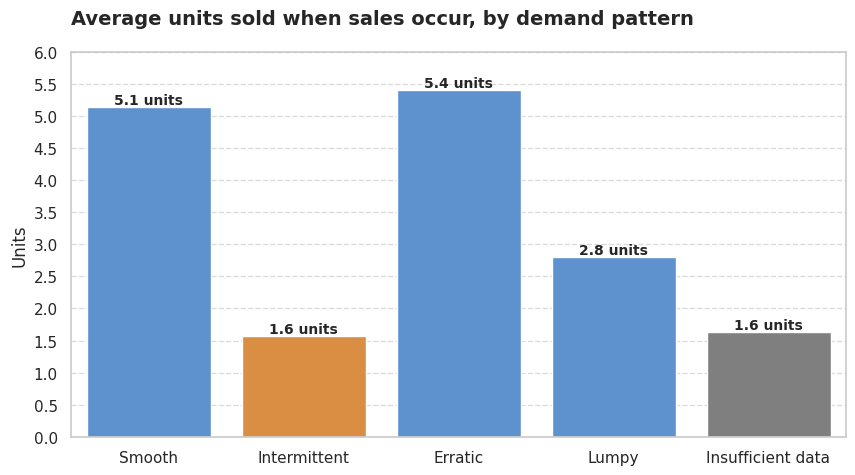

In [ ]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10,5))

ax = sns.barplot(   # <- aquí guardamos el eje
    data=demand_summary_gb,
    x='demand_type',
    y='mean_avg_sales',
    palette=palette,
    hue='demand_type',
    legend=False,
    dodge=False
)


plt.title("Average units sold when sales occur, by demand pattern", fontsize=14, weight="bold", loc='left', pad=20)
plt.xlabel("")
plt.ylabel("Units")

plt.ylim(0, 6)
plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(0.5))

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f} units', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=10, weight='bold')

plt.grid(axis='y', alpha=0.7, linestyle='--')

plt.show()

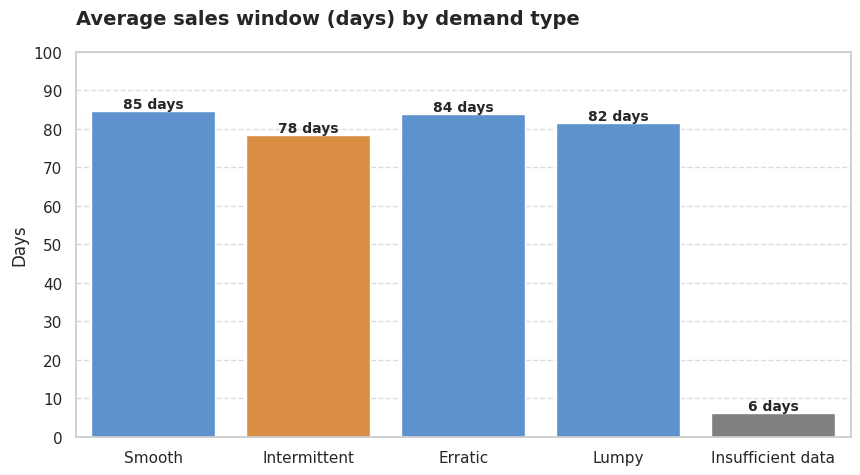

In [ ]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10,5))

ax = sns.barplot(  
    data=demand_summary_gb,
    x='demand_type',
    y='sales_window_days',
    palette=palette,
    hue='demand_type',
    legend=False,
    dodge=False
)

plt.title("Average sales window (days) by demand type", fontsize=14, weight="bold", loc='left', pad=20)
plt.xlabel("")
plt.ylabel("Days")

plt.ylim(0, 100)
plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(10))

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0f} days', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=10, weight='bold')

plt.grid(axis='y', alpha=0.7, linestyle='--')

plt.show()

## b) Examples

In [ ]:
# Define representative examples for each demand type
intermittent_item = 'HOBBIES_1_366_CA_1_validation'
smooth_item       = 'HOBBIES_1_275_TX_2_validation'
erratic_item      = 'HOUSEHOLD_1_177_WI_3_validation'
lumpy_item        = 'FOODS_1_143_CA_1_validation'
insdata_item      = 'FOODS_1_138_CA_4_validation'

items = [intermittent_item, smooth_item, erratic_item, lumpy_item, insdata_item]

# DuckDB query: extract only the selected items and their metrics
query = """
SELECT
    demand_type, item_id, store_id,
    first_sale_date, last_sale_date, sales_window_days, selling_days, ADI,
    avg_sales, std_sales, CV2
FROM demand_summary
WHERE id IN $items
ORDER BY demand_type
"""

# Execute query and return result as a Pandas DataFrame
sample_df = con.execute(query, {"items": items}).df().round(2)

sample_df

,demand_type,item_id,store_id,first_sale_date,last_sale_date,sales_window_days,selling_days,ADI,avg_sales,std_sales,CV2
0,Smooth,HOBBIES_1_275,TX_2,2015-04-01,2015-06-30,90,87,1.03,2.98,1.40,0.22
1,Intermittent,HOBBIES_1_366,CA_1,2015-04-06,2015-06-30,85,23,3.70,1.22,0.41,0.12
2,Erratic,HOUSEHOLD_1_177,WI_3,2015-04-01,2015-06-30,90,85,1.06,2.80,2.10,0.56
3,Lumpy,FOODS_1_143,CA_1,2015-04-03,2015-06-26,84,35,2.40,2.09,1.75,0.70
4,Insufficient data,FOODS_1_138,CA_4,2015-04-01,2015-04-07,6,3,2.00,3.67,3.09,0.71


In [ ]:
query = f"""
SELECT
    *
FROM read_parquet('{SALES_DATA_PATH}')
LEFT JOIN demand_summary USING(id)
WHERE id IN {tuple(items)}
AND year = 2015 and quarter = 2
ORDER BY id, date
"""

sample_sales = ddb.query(query).to_df()

sample_sales = sample_sales[['demand_type','date', 'sales']]

In [ ]:
import plotly.express as px

fig = px.line(
    sample_sales,
    x="date",
    y="sales",
    color="demand_type",
    category_orders={"demand_type": ['Smooth', 'Intermittent', 'Erratic', 'Lumpy', 'Insufficient data']},
    markers=False,
    title="Daily sales samples by demand type (Q2 2015)",
    labels={
        "date": "Date",
        "sales": "Sales",
        "demand_type": "Demand type sample"
    },
    template="plotly_white",
    color_discrete_sequence=px.colors.qualitative.Set1,
    width=1200, height=500
)

fig.update_traces(line=dict(
    width=2)
    )

fig.update_layout(
    title=dict(
        x=0.5,
        font=dict(size=22,
                family="Arial",
                color="black")
    ),
    xaxis=dict(
        showgrid=False,
        gridcolor="lightgray",
        tickangle=0,
        gridwidth=1,
        griddash='dot'
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor="lightgray",
        gridwidth=1,
        griddash='dot',
        tick0=0,
        dtick=1,          # <-- ahora de 1 en 1
        range=[0, 13]
    ),
    legend=dict(
        title="Sample pattern",
        orientation="v",
        xanchor="center",
        x=1.1,
        y=1,
    )
)

fig.show()

# Forecasting

In [ ]:
def naive_model(series: pd.Series) -> pd.Series:
    """
    Forecast Naive: simplemente usa el valor anterior.
    Devuelve NaN en la primera posición.
    """
    return series.shift(1).round(0).astype('Int16')


def ses_model(series: pd.Series, alpha: float = 0.5) -> pd.Series:
    """
    Simple Exponential Smoothing con NumPy.
    alpha: factor de suavizamiento (0<alpha<=1).
    """
    values = series.to_numpy(dtype=float)
    result = np.empty_like(values, dtype=float)
    
    result[0] = values[0]

    for t in range(1, len(values)):
        result[t] = alpha * values[t] + (1 - alpha) * result[t-1]
    
    return pd.Series(result, index=series.index).round(0).astype('Int16')

sample_sales["naive_forecast"] = (
    sample_sales.groupby("demand_type", observed=True)["sales"]
    .transform(naive_model)
)

sample_sales["ses_forecast"] = (
    sample_sales.groupby("demand_type", observed=True)["sales"]
    .transform(lambda x: ses_model(x, alpha=0.5))
)


In [ ]:
smooth_sales = sample_sales[sample_sales['demand_type'] == 'Smooth'].copy()

fig = px.line(
    smooth_sales,
    x="date",
    y=["sales", "naive_forecast", "ses_forecast"],  # varias series
    labels={
        "value": "Unidades",
        "date": "Fecha",
        "variable": "Serie"
    },
    title="Ventas y Pronósticos (Naive vs SES) - Smooth",
    template="plotly_white",
    width=1200, height=500
)

fig.update_traces(line=dict(width=2))
fig.show()

In [ ]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mdae(y_true, y_pred):
    return np.median(np.abs(y_true - y_pred))  

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true - np.mean(y_true)))

def bias(y_true, y_pred):
    return np.sum(y_pred - y_true) / np.sum(y_true)

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0  # evita dividir por cero
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))

def mase(y_true, y_naive, y_pred):
    n = len(y_true)
    num = np.sum(np.abs(y_true - y_pred)) / n
    den = np.sum(np.abs(y_true - y_naive)) / n
    return np.round(num / den, 3)

In [ ]:
metrics_list = []

for item in demand_categories:
    item_sales = sample_sales[sample_sales['demand_type'] == item]

    total_sales = item_sales['sales'].sum()
    total_naive_forecast = item_sales['naive_forecast'].sum()
    total_ses_forecast = item_sales['ses_forecast'].sum()
    
    metrics_list.append({
        "demand_type": item,
        "total_sales": total_sales,
        "total_naive_forecast": total_naive_forecast,
        "total_ses_forecast": total_ses_forecast,
        "rmse_naive": rmse(item_sales['sales'], item_sales['naive_forecast']),
        "rmse_ses": rmse(item_sales['sales'], item_sales['ses_forecast']),
        "wape_naive": wape(item_sales['sales'], item_sales['naive_forecast']),
        "wape_ses": wape(item_sales['sales'], item_sales['ses_forecast']),
        "bias_naive": bias(item_sales['sales'], item_sales['naive_forecast']),
        "bias_ses": bias(item_sales['sales'], item_sales['ses_forecast']),
        "mase_ses": mase(item_sales['sales'], item_sales['naive_forecast'], item_sales['ses_forecast'])
    })

summary_metrics = pd.DataFrame(metrics_list).round(3)

In [ ]:
summary_metrics

,demand_type,total_sales,total_naive_forecast,total_ses_forecast,rmse_naive,rmse_ses,wape_naive,wape_ses,bias_naive,bias_ses,mase_ses
0,Smooth,259,256,258,1.975,0.955,1.350,0.624,-0.004,-0.004,0.462
1,Intermittent,28,26,26,0.803,0.296,1.051,0.191,-0.071,-0.071,0.182
2,Erratic,238,236,241,2.996,1.271,1.289,0.517,0.008,0.013,0.401
3,Lumpy,73,73,72,2.060,0.908,1.224,0.479,0.000,-0.014,0.391
4,Insufficient data,11,11,12,1.145,0.503,0.846,0.423,0.182,0.091,0.500
